# Estimate model of WTI oil futures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()



Download dataset with latest data
(Data is for every business day)

In [2]:
raw_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RCLC1d.xls", sheet_name=1, header=2)

In [3]:
raw_data.head()

,Date,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
0,1983-04-04,29.44
1,1983-04-05,29.71
2,1983-04-06,29.92
3,1983-04-07,30.17
4,1983-04-08,30.38


In [4]:
# check date of the oldest and the newest entry
print("Oldest entry: ", raw_data["Date"].min())
print("Newest entry: ", raw_data["Date"].max())

Oldest entry:  1983-04-04 00:00:00
Newest entry:  2020-03-19 00:00:00


In [5]:
# set date as index for easier time series handling
time_indexed_data = raw_data.set_index("Date")
time_indexed_data.head()

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
Date,
1983-04-04,29.44
1983-04-05,29.71
1983-04-06,29.92
1983-04-07,30.17
1983-04-08,30.38


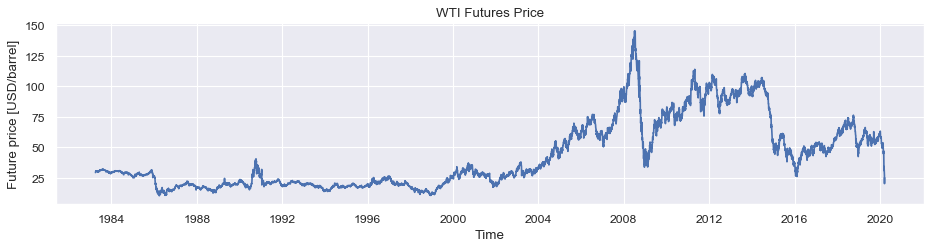

In [6]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time_indexed_data)
plt.title("WTI Futures Price")
plt.xlabel("Time")
plt.ylabel("Future price [USD/barrel]")
plt.show()

Select time interval

In [7]:
selected_ti = time_indexed_data.loc["2015-01-01":"2019-12-31"]
selected_ti.count()

Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)    1261
dtype: int64

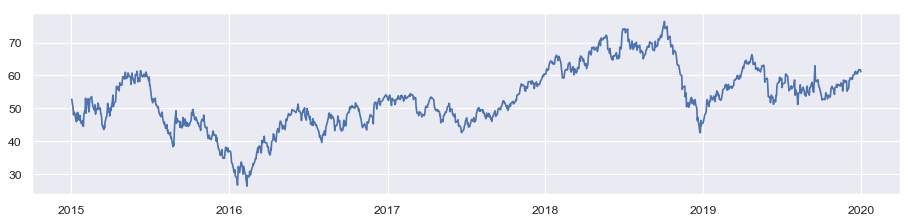

In [8]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(selected_ti)
plt.show()

In [22]:
rets = selected_ti/selected_ti.shift(1)
rets = rets[rets.columns[0]].dropna()

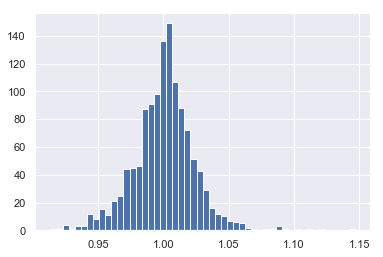

In [27]:
plt.hist(rets,bins=50)
plt.show()

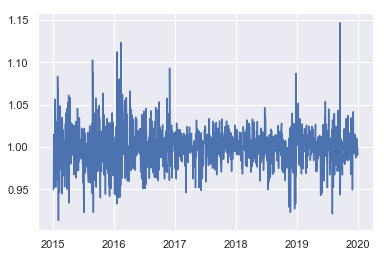

In [23]:
plt.plot(rets)

In [24]:
lrets = np.log(rets)
lrets.head()

Date
2015-01-05   -0.051603
2015-01-06   -0.043081
2015-01-07    0.014910
2015-01-08    0.002874
2015-01-09   -0.008852
Name: Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel), dtype: float64

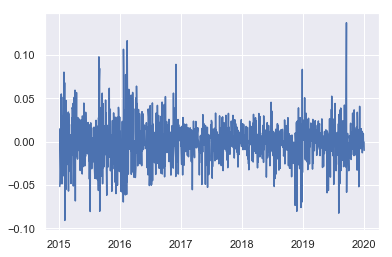

In [25]:
plt.plot(lrets)
plt.show()

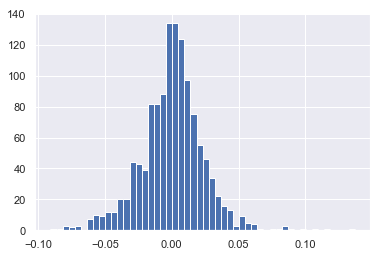

In [21]:
plt.hist(lrets,bins=50)
plt.show()

Transform the returns to be normally distributed

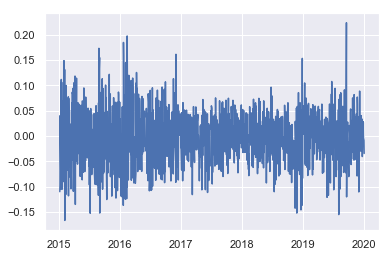

In [30]:
d_med = np.median(lrets)
center_dif = lrets - d_med
rets1 = np.sign(center_dif)*(np.abs(center_dif)**(3.0/4.0))
plt.plot(rets1)

Check normality

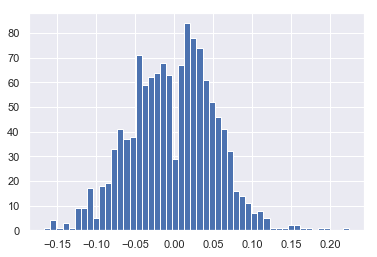

In [32]:
plt.hist(rets1,bins=50)
plt.show()

In [145]:
from helper_functions.evaluate_timeseries import evaluate_ts_data


Jarque Bera test
     Score   p value
0  2.07849  0.353722

Ljung-Box test
      lb_stat  lb_pvalue
30  31.921261   0.371198


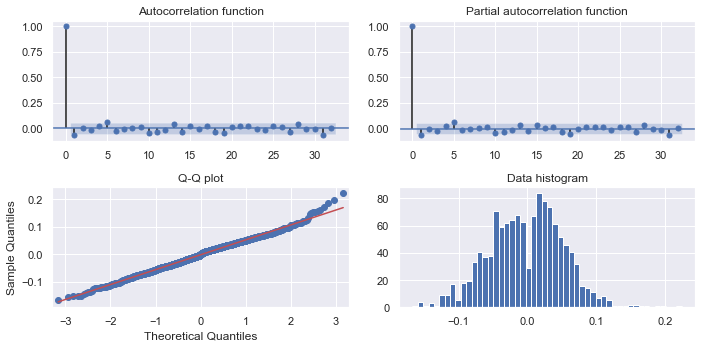

In [147]:
evaluate_ts_data(rets1)

Entries transformed in such way are successfully evaluated as normally distributed without any autocorrelation
Next step is to estimate param